# Game Music dataset: genre classification

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix

In [181]:
df_genres = pd.read_csv('midi_dataframe_genres_flattened.csv', parse_dates=[11], index_col='file_name')

num_games = len(df.groupby(['tgdb_platform', 'tgdb_gametitle']))
print('There is %d midi files, from %d games, with %d midis matched with tgdb'
      %(len(df_genres.groupby('file_name')),
        num_games,
        (df.tgdb_gametitle.notnull().sum())))

df_features = pd.read_csv('features.csv').set_index('file_name')
print("There is %d midi files with computed features"%(len(df_features)))

print("After removing not valid midi files, we have %d files"%(len(df_genres.join(df_features, how='inner').groupby('file_name'))))

There is 22179 midi files, from 3243 games, with 22179 midis matched with tgdb
There is 31483 midi files with computed features
After removing not valid midi files, we have 22005 files


# Problem statement

By joining the game music dataframe with the features dataset produced by JSimbolic, the final dataset to be used for the classification task is obtained.

This dataset provides 156 musical feature for each valid midi. 

In [12]:
df_pred = df_genres[['genre']].join(df_features, how='inner').reset_index()
df_pred = df_pred.replace([np.inf, -np.inf], np.nan).dropna()
df_pred.head()

,file_name,genre,Prevalence_of_Most_Common_Pitch,Prevalence_of_Most_Common_Pitch_Class,Relative_Prevalence_of_Top_Pitches,Relative_Prevalence_of_Top_Pitch_Classes,Interval_Between_Most_Prevalent_Pitches,Interval_Between_Most_Prevalent_Pitch_Classes,Number_of_Common_Pitches,Pitch_Variety,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,0004cc74bde3bc82f44afb5f566187c3dbcea9b2.mid,Platform,0.1593,0.2242,0.7222,0.7500,5.0,5.0,2.0,28.0,...,0.0000,0.0,0.0000,0.00000,0.0,0.0,63.0,17.65,6.3240,13.7800
1,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Action,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
2,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Adventure,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
3,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Sports,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128
4,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Strategy,0.1316,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.6522,0.0,0.2609,0.08696,0.0,0.0,47.0,19.18,0.8643,0.3128


To simplify this first analysis, only the categories which are the most represented in the dataset will be considered, we set the threshold at 2000. 

In [13]:
df_counts = df_genres.groupby('genre').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
df_counts

,genre,counts
0,Action,8524
12,Role-Playing,6617
9,Platform,5040
1,Adventure,4802
14,Shooter,2248
3,Fighting,1848
10,Puzzle,1483
15,Sports,1122
17,Strategy,1098
11,Racing,813


In [16]:
df_pred = df_pred[df_pred.genre.isin(df_counts[df_counts.counts > 2000]['genre'])]
print("For this first analysis, 5 genres entailing " + str(df_pred.shape[0]) + " MIDIs will be considered.")
print('The genres are: %s'%", ".join(np.unique(df_pred['genre'])))

For this first analysis, 5 genres entailing 27010 MIDIs will be considered.
The genres are: Action, Adventure, Platform, Role-Playing, Shooter


The dataset is divided into features and labels - X and y respectively - for the purpose of the classification task. The labels Y are mapped to integers to comply with the requirements of certain Machine Learning models such as linear regression.

In [31]:
X = df_pred.iloc[:, 2:]
y, labels = pd.factorize(df_pred['genre'])

The dataset is split into training and testing sets with a 8-2 ratio, which seems very reasonable considering the size of the dataset.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=42)
print(str(X_train.shape[0]) + " MIDIs are used for training, " + str(X_test.shape[0]) + " are used for testing.")

21608 MIDIs are used for training, 5402 are used for testing.


# Models Evaluation

In this section various Machine Learning classification models are used with the goal of identifying the one who best fits the task. The models take as input the whole set of features and perform the classification task.

But before anything else, let's take a look at the repartition of the genres in the whole dataset, the train and the test sets.

In [67]:
val, counts_dataset = np.unique(y, return_counts=True)
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame([counts_dataset/counts_dataset.sum(), counts_train/counts_train.sum(), counts_test/counts_test.sum()],\
             columns=[labels[i] for i in val], index=['Full data', 'Train data', 'Test data'])

,Platform,Action,Adventure,Role-Playing,Shooter
Full data,0.184783,0.312514,0.177453,0.242355,0.082895
Train data,0.183913,0.313032,0.176046,0.244400,0.082608
Test data,0.188264,0.310441,0.183080,0.234173,0.084043


The the data is present in similar proportion in each set (columns), however it is not the case for each genre.

For comparison with other classifier, let's consider a classifier called $dummy$ that returns the most common class, "Action", everytime, this classifier would have 31% accuracy.

As a first approach, a multinomial logistic classifier is used.

In [68]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(solver='lbfgs', multi_class="multinomial", penalty="l2")
clf.fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print("The Logistic Regression classifier predicts correclty of %.3f%% of the training test and of %.3f%% of the testing set"\
      %(train_score*100, test_score*100))

The Logistic Regression classifier predicts correclty of 37.370% of the training test and of 35.690% of the testing set


A first observation is that the training and eror accuracy are quite similar, indicitating no obvious sign of over or under-fitting.

The second observation is that the model performs very poorly, beating $dummy$ by only 4%, let's look at the confusion matrix to see where the mistakes are made.

A confusion matrix may help understanding the mistakes.

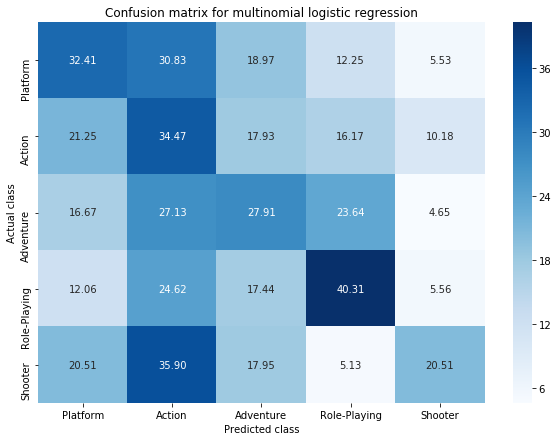

In [127]:
arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for multinomial logistic regression")
plt.show();

This confusion matrix is shown in term of percentage of classification per class, for example, platforms games have been classified in 32.4% of the case as platform, but 30.8% of the case as action.

This matrix shows that most of the confusion is due to Action (the most represented class), in nearly all the cases, genres are majoritarily predicted as Action.

The genre that is the best classified is the "Role-Playing", an explanation could be that it has the most distinguishable music style. Indeede many Role-Playing games have a medieval-fantasy setting, thus its music often borrows lots of musical features of epic register akin to some of the works of Debussy and Wagner.

Since this linear model performs poorly for the given task, it may be the case that the data is not linearly separable, thus an ensemble model was tested.

Since random forest parameters can be tricky to choose and make greatly variate the results, a simple grid-search was performed.

The best accuracy was 34.39% with parameters {'n_estimator': 26.5, 'max_depth': 2.0, 'max_feature': 'log2'}


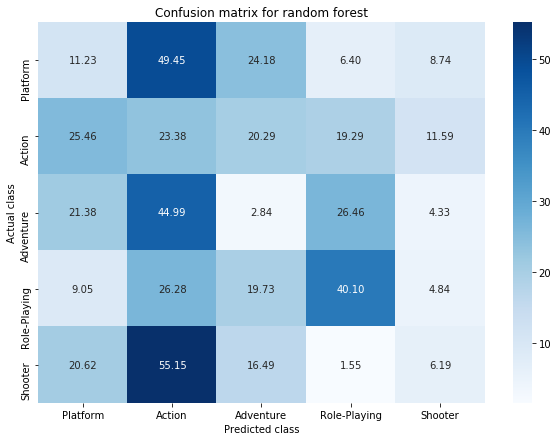

In [164]:
n_estimators = np.linspace(2, 100, 5)
max_depths = np.linspace(2, 50, 5)
max_features = ['sqrt', 'log2']
best_score = 0.0
best_params = []
for n_estimator in n_estimators:
    for max_depth in max_depths:
        for max_feature in max_features:
            params = {'n_estimator': n_estimator, 'max_depth': max_depth, 'max_feature': max_feature}
            clf = RandomForestClassifier(n_estimators=int(n_estimator), max_depth=int(max_depth), max_features=max_feature, random_state=1)
            clf.fit(X_train, y_train)
            score = clf.score(X_test, y_test)
            if score > best_score:
                best_score = score
                best_params = params
                
print("The best accuracy was %.2f%% with parameters %s"%(best_score*100, best_params))
rfc = RandomForestClassifier(\
                             n_estimators=int(best_params['n_estimator']),\
                             max_depth=int(best_params['max_depth'],\
                             max_features=best_params['max_feature'])
rfc.fit(X_train, y_train)
arr = confusion_matrix(clf.predict(X_test), y_test)
arr = arr/arr.sum(axis=1).reshape(1,-1).T*100
df_cm = pd.DataFrame(arr, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))

sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel("Predicted class")
plt.ylabel("Actual class")
plt.title("Confusion matrix for random forest")
plt.show();

The accuracy of the classification did not improve even by using this model that should be able to fit not linearly separable data. The confusion matrix is similar to the one previously shown, showing even worse results.

A kernel method was also tested to see if mapping data in a more complex space would help.

In [12]:
clf = SVC(kernel = 'rbf', gamma=1)
clf.fit(X_train, y_train) 
score = clf.score(X_test, y_test)

train_score = rfc.score(X_train, y_train)
test_score = rfc.score(X_test, y_test)

print("The kernelized SVC classifier yields a score of " + str(train_score) + "on the training test " +
      " and of " + str(test_score) + " on the testing set")

The kernelized SVC classifier yields a score of 0.2802907915993538


The performance is even worse. so this hypothesis isn't the right one.

Another possibility is that the features aren't informative enough. 

To get an idea of how informative the features ares, let's plot the feature\_importances\_ attribute of the Random Forest classifier.

Text(0.5,1,'Role of the components in term of variance (30 principal components)')

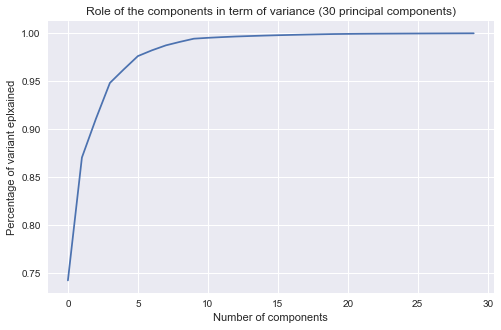

In [186]:
pca = PCA(n_components=X.shape[1])
pca.fit(X)
plt.figure(figsize=(8,5))
plt.plot(pca.explained_variance_ratio_.cumsum()[:30])
plt.xlabel('Number of components')
plt.ylabel('Percentage of variant eplxained')
plt.title("Role of the components in term of variance (30 principal components)")

In [192]:
df_pred

,file_name,genre,Prevalence_of_Most_Common_Pitch,Prevalence_of_Most_Common_Pitch_Class,Relative_Prevalence_of_Top_Pitches,Relative_Prevalence_of_Top_Pitch_Classes,Interval_Between_Most_Prevalent_Pitches,Interval_Between_Most_Prevalent_Pitch_Classes,Number_of_Common_Pitches,Pitch_Variety,...,Parallel_Motion,Similar_Motion,Contrary_Motion,Oblique_Motion,Parallel_Fifths,Parallel_Octaves,Dynamic_Range,Variation_of_Dynamics,Variation_of_Dynamics_In_Each_Voice,Average_Note_to_Note_Change_in_Dynamics
0,0004cc74bde3bc82f44afb5f566187c3dbcea9b2.mid,Platform,0.15930,0.2242,0.7222,0.7500,5.0,5.0,2.0,28.0,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,63.0,17.650,6.3240,13.7800
1,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Action,0.13160,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.652200,0.00000,0.260900,0.08696,0.000000,0.000000,47.0,19.180,0.8643,0.3128
2,0005d95e4aed74b84826f6090fcc8e52bceb5cb3.mid,Adventure,0.13160,0.2368,0.6000,0.7037,5.0,7.0,1.0,20.0,...,0.652200,0.00000,0.260900,0.08696,0.000000,0.000000,47.0,19.180,0.8643,0.3128
5,00068e4ce263089f1c60d7eda59b3911bac44fea.mid,Role-Playing,0.17370,0.3215,0.8037,0.9109,19.0,5.0,6.0,18.0,...,0.058820,0.40060,0.072830,0.46780,0.028010,0.000000,61.0,10.660,9.8330,0.1922
6,0008501bdcc7c8ddc9c228819986f7439cb9a8f5.mid,Adventure,0.13450,0.2461,0.8797,0.9471,43.0,7.0,4.0,28.0,...,0.107600,0.46370,0.055230,0.37350,0.062500,0.007267,125.0,27.310,11.2000,2.4050
7,0008501bdcc7c8ddc9c228819986f7439cb9a8f5.mid,Role-Playing,0.13450,0.2461,0.8797,0.9471,43.0,7.0,4.0,28.0,...,0.107600,0.46370,0.055230,0.37350,0.062500,0.007267,125.0,27.310,11.2000,2.4050
8,00097280d2d825f163aecfa7ccf69504db467d1d.mid,Role-Playing,0.07019,0.1578,0.9524,0.9915,5.0,5.0,0.0,52.0,...,0.231500,0.16950,0.133700,0.46540,0.009547,0.107400,62.0,13.000,2.9850,1.8230
9,000b1786fba7f8c9e3d8c26a29e893e87e82e463.mid,Platform,0.12120,0.2424,1.0000,0.8750,7.0,7.0,3.0,18.0,...,0.555600,0.22220,0.000000,0.22220,0.000000,0.000000,41.0,19.180,0.0000,0.0000
10,000d977eb0547ee6bbf96a1850766a3d6676aa03.mid,Role-Playing,0.11970,0.3359,0.9032,0.5862,12.0,3.0,4.0,23.0,...,0.036360,0.10910,0.127300,0.72730,0.000000,0.000000,43.0,18.050,0.0000,0.0000
12,000e6a7f5511e138666751cc8a5f9421777305f1.mid,Action,0.27720,0.2772,0.5486,0.6781,5.0,7.0,2.0,25.0,...,0.297000,0.32480,0.142600,0.23560,0.000000,0.013860,104.0,23.360,7.7870,12.5000


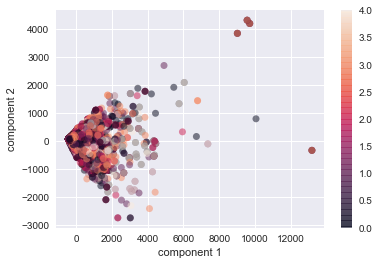

In [190]:
projected = pca.transform(X)
plt.scatter(projected[:, 0], projected[:, 1],
            c=y, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Feature ranking:
1. feature 126 (0.048527)
2. feature 124 (0.026664)
3. feature 94 (0.025603)
4. feature 95 (0.021205)
5. feature 127 (0.018558)
6. feature 112 (0.014409)
7. feature 96 (0.012706)
8. feature 30 (0.010366)
9. feature 101 (0.010174)
10. feature 62 (0.010117)
11. feature 129 (0.009961)
12. feature 105 (0.009563)
13. feature 97 (0.009040)
14. feature 11 (0.009025)
15. feature 102 (0.008940)
16. feature 63 (0.008800)
17. feature 12 (0.008642)
18. feature 1 (0.008546)
19. feature 141 (0.008497)
20. feature 49 (0.008496)
21. feature 13 (0.008390)
22. feature 92 (0.008253)
23. feature 117 (0.008208)
24. feature 70 (0.008109)
25. feature 140 (0.008081)
26. feature 66 (0.008060)
27. feature 33 (0.008004)
28. feature 43 (0.007927)
29. feature 41 (0.007918)
30. feature 57 (0.007781)
31. feature 31 (0.007780)
32. feature 100 (0.007769)
33. feature 44 (0.007754)
34. feature 0 (0.007676)
35. feature 9 (0.007672)
36. feature 14 (0.007475)
37. feature 3 (0.007461)
38. feature 104 (0.007

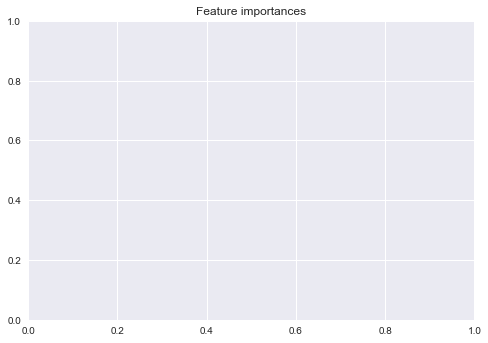

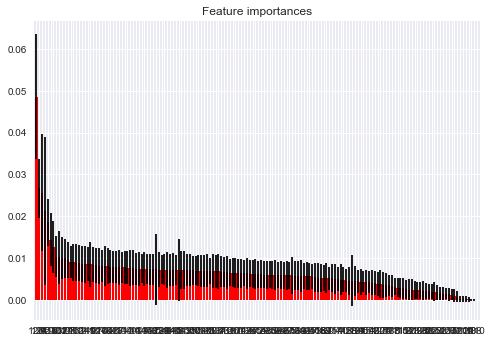

In [22]:
importances = rfc.feature_importances_

std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Let's try applying PCA to the features to see what happens.

In [14]:
pca = PCA(n_components=3)
pca.fit(X)
pca.explained_variance_ratio_

array([0.75146483, 0.12196016, 0.04089509])

The answer is very informative: the 1st principal component accounts for 75% of the variance in the dataset and the three first components account for 90%. This intuitevely means that the information relevant for the classification task tends to be centered towards determinate features, as opposed to being spread evenly in the dataset.

The next step is trying to identify these relevant features.

## Wrap-up

- Problems, why? How to solve?
  - Bad midis, because of users (extreme tempo)
  - Bad features, for our purpose from JSymbolic? Supported by results? Some features seems useless
  - Several genres by midi, over-representation of action
- Both analysis done in parallel, but in ML4 will converge
- Next steps
  - Select feature by feature, incremental process, feature verified by "hand"
  - 